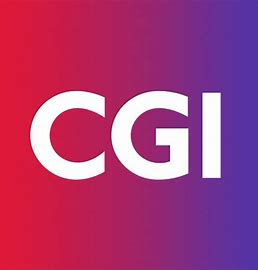

In [3]:
# @title Installing Required packages
%pip install openai
%pip install jira

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: mermaid 0.3.2 has a non-standard dependency specifier torch>=1.7torchvision. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mermaid or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: mermaid 0.3.2 has a non-standard dependency specifier torch>=1.7torchvision. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mermaid or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
# @title Importing dependencies
from openai import OpenAI
from openai import Client
import spacy
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import requests
from requests.auth import HTTPBasicAuth
import urllib3
import csv
from datetime import datetime
from google.colab import userdata

ImportError: cannot import name 'OpenAI' from 'openai' (C:\Users\divya.eesarla\AppData\Local\anaconda3\Lib\site-packages\openai\__init__.py)

In [6]:
# @title Function: Speech-to-text
def transcribe_audio(file_path):
    client = Client(api_key=userdata.get('api_key'))

    try:
        with open(file_path, "rb") as audio_file:
            transcript = client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file
            )
            return transcript.text
    except Exception as e:
        return f"Error: {e}"

In [7]:
# @title Function: Prompt intake
def generate_chat(prompt, transcript_text, temperature=0.1):
    client = Client(api_key=userdata.get('api_key'))
    try:
        stream = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=[
                {"role": "system", "content": prompt},
                {"role": "system", "content": transcript_text}
            ],
            stream=True,
            temperature=temperature,
        )
        content_list = []
        for chunk in stream:
            if chunk.choices[0].delta.content is not None:
                content_list.append(chunk.choices[0].delta.content)
        stored_content = "".join(content_list)
        return stored_content
    except Exception as e:
        return f"Error: {e}"

In [ ]:
# @title Function: Seperating MoM from Summary
nlp = spacy.load("en_core_web_sm")

def separate_minutes(text):
    start_index = text.find("**Minutes of Meeting**")
    minutes_part = text[start_index:]
    remaining_text = text[:start_index]
    minutes_doc = nlp(minutes_part)
    minutes_sentences = [sent.text.strip() for sent in minutes_doc.sents]

    return minutes_sentences, remaining_text

def process_text(text):
    minutes_sentences, remaining_text = separate_minutes(text)
    output_variable = ""
    for sentence in minutes_sentences:
        output_variable += "- " + sentence + "\n"

    return output_variable, remaining_text

In [9]:
from exchangelib import Credentials, Account, DELEGATE, HTMLBody, Message

def send_mom(subject, attendees, agenda_items, proceedings, action_items):
    email = "divya.eesarla@cgi.com"
    password = "de999.cgi"


    credentials = Credentials(email, password)


    account = Account(email, credentials=credentials, autodiscover=True, access_type=DELEGATE)


    mom_content = f"""
    <h2>Minutes of Meeting</h2>
    <p><strong>Subject:</strong> {subject}</p>
    <p><strong>Date:</strong> 09/03/24</p>
    <p><strong>Time:</strong> 10:30 am</p>
    <p><strong>Location:</strong> Teams</p>

    <h3>Attendees:</h3>
    <ul>
    """
    for attendee in attendees:
        mom_content += f"<li>{attendee}</li>"
    mom_content += "</ul>"

    mom_content += """
    <h3>Agenda:</h3>
    <ol>
    """
    for item in agenda_items:
        mom_content += f"<li>{item}</li>"
    mom_content += "</ol>"

    mom_content += """
    <h3>Proceedings:</h3>
    <ul>
    """
    for proceeding in proceedings:
        mom_content += f"<li>{proceeding}</li>"
    mom_content += "</ul>"

    mom_content += """
    <h3>Action Items:</h3>
    <ol>
    """
    for action_item in action_items:
        mom_content += f"<li>{action_item}</li>"
    mom_content += "</ol>"

    mom_content += """
    <h3>Next Meeting:</h3>
    <p><strong>Date:</strong> 09/03/24</p>
    <p><strong>Time:</strong> 10:30 am</p>
    <p><strong>Location:</strong> Teams</p>
    """


    msg = Message(
        account=account,
        subject="Minutes of Meeting - 09/03/24",
        body=HTMLBody(mom_content),
        to_recipients=["divya.eesarla@cgi.com"],
    )


    try:
        msg.send()
        print("Minutes of Meeting sent successfully!")
    except Exception as e:
        print(f"Error occurred while sending the email: {str(e)}")


subject = "Discussion on Project Progress"
attendees = ["Krishna", "Saptarshi", "Afressa"]
agenda_items = ["Task updates from yesterday.", "Plans for the day."]
proceedings = [
    "The meeting commenced with Saptarshi providing an update on his completed task of implementing authentication in the backend.",
    "Saptarshi mentioned that he will be working on implementing authorization using JWT tokens today.",
    "Afressa shared her plan to work on the frontend and integrate the authentication part once Saptarshi completes his backend work.",
    "It was agreed that once Saptarshi finishes the authorization implementation, Afressa will proceed with integrating it into the frontend."
]
action_items = [
    "Saptarshi to work on implementing authorization using JWT tokens.",
    "Afressa to integrate the authentication part into the frontend once Saptarshi completes his backend work."
]

send_mom(subject, attendees, agenda_items, proceedings, action_items)


Minutes of Meeting sent successfully!


In [ ]:
# @title Input: Enter your audio file
audio_file_path = "speech1.mp3"
audioOutput = transcribe_audio(audio_file_path)
print(audioOutput)

Hello Saptarshi, good morning. Hello Afrisha, good morning. Hi Krishna, good morning. Hi Krishna, good morning. So Saptarshi and Afrisha, let us start this meeting without any delay. So Saptarshi, tell me your updates about yesterday, what you did. So hi Krishna, I was working on the authentication in the backend for our IP. So the authentication part is done. Now authorization part using JWT token is ongoing. I will do today and by the end of this week, that is in next two days, I will complete it. So that is my status and the work is still in progress. Okay Saptarshi, that's good. Afrisha, what is your update? Krishna, I was working on the authentication part in the frontend and same authentication is completed but authorization is yet to be implemented and I will implement it today and upload it and complete it by this week which is in next two days. So that was the update. Okay, so you both heard your work is still in progress, right? Okay, so let's do this work and complete it by 

In [ ]:
# @title Input: Enter your prompt to summarize
prompt = """ Summarize the paragraph in points and make a detailed and formal MoM out it."""
transcript_text = audioOutput
MoM_Summary = generate_chat(prompt, transcript_text)
print(MoM_Summary)

- Saptarshi worked on authentication in the backend for the IP project, authentication part is completed and authorization using JWT token is ongoing.
- Afrisha worked on authentication in the frontend for the same project, authentication part is completed and authorization is yet to be implemented.
- Both team members plan to complete the authorization part by the end of the week, within the next two days.
- The work is still in progress, and the team aims to finish it on time.

**Minutes of Meeting**

Date: [Insert Date]
Time: [Insert Time]
Location: [Insert Location]

Attendees:
- Saptarshi
- Afrisha
- Krishna

Agenda:
- Updates on project progress
- Discussion on completion timeline

Summary:
- Saptarshi reported that he completed the authentication part in the backend for the IP project and is currently working on the authorization using JWT token, with plans to finish it by the end of the week.
- Afrisha shared that she finished the authentication part in the frontend and is yet 

In [ ]:
# @title Storing MOM and summary in variables
# Example usage:
output_variable, remaining_text = process_text(MoM_Summary)
print(output_variable)
print("\nRemaining text:")
print(remaining_text)

- **Minutes of Meeting**

Date:
- [Insert Date]
- Time:
- [Insert Time]
Location:
- [Insert Location]

Attendees:
- Saptarshi
- Afrisha
- Krishna

Agenda:
- Updates on project progress
- Discussion on completion timeline

Summary:
- Saptarshi reported that he completed the authentication part in the backend for the IP project and is currently working on the authorization using JWT token, with plans to finish it by the end of the week.
- Afrisha shared that she finished the authentication part in the frontend and is yet to implement authorization, aiming to complete it by the end of the week as well.
- Both team members confirmed that the work is still in progress and they are on track to complete it within the next two days.
-
- The team agreed to focus on completing the authorization part on time.
- Action Items:
- Saptarshi to continue working on the authorization using JWT token and complete it by the end of the week.
- - Afrisha to implement authorization in the frontend and ensure

In [ ]:
# @title Input: Extract tasks
prompt1 = """Extract data like Task they are working on, Type, Users, Start Date, End Date, Priority, Estimated time and status from the transcript. Output format like this (paricipents name, figure it out) Task: Findout what they are working on.
- (paricipents name, figure it out) Task: Findout what they are working on.
- Start Date: Any date if they mentioned.
- End Date: Any date if they mentioned.
- Priority: Figure out the priorty from their sentiment.
- Estimated Time: Any time they mentioned.
- Status: figure out if they have compleated or still doing it"""
TaskExtract = generate_chat(prompt1, audioOutput)
print(TaskExtract)

- Saptarshi
- Task: Working on authentication in the backend for IP, authorization part using JWT token is ongoing
- Start Date: Not mentioned
- End Date: By the end of the week (in next two days)
- Priority: High (based on the urgency to complete by the end of the week)
- Estimated Time: Not mentioned
- Status: Work is still in progress

- Afrisha
- Task: Working on authentication part in the frontend, authorization is yet to be implemented
- Start Date: Not mentioned
- End Date: By the end of the week (in next two days)
- Priority: High (based on the urgency to complete by the end of the week)
- Estimated Time: Not mentioned
- Status: Work is still in progress


In [ ]:
# @title Input: Additional Info
prompt2 = """ today is 8/3/2024, i did this 2 days ago, end date is next week, estimated time 5days or 45hrs other info is correct and give out the results in the format the input was given, spetrate the task for the users"""
data_Input = generate_chat(prompt2, TaskExtract)
print(data_Input)

### Saptarshi's Task Update:
- Task: Working on authentication in the backend for IP, authorization part using JWT token
- Start Date: 8/1/2024
- End Date: By the end of the week (8/9/2024)
- Estimated Time: 5 days or 45 hours
- Status: Work is still in progress

### Afrisha's Task Update:
- Task: Working on authentication part in the frontend, authorization is yet to be implemented
- Start Date: 8/1/2024
- End Date: By the end of the week (8/9/2024)
- Estimated Time: Not mentioned
- Status: Work is still in progress


In [ ]:
# @title Input: Data formating
prompt3 = """Now put it in a format where the data can be extracted like in a csv format, and mention the column names, remove all text formating"""
formatting = generate_chat(prompt3, data_Input)
print(formatting)

Task,Name,Start Date,End Date,Estimated Time,Status
Saptarshi's Task Update,Working on authentication in the backend for IP, authorization part using JWT token,8/1/2024,By the end of the week (8/9/2024),5 days or 45 hours,Work is still in progress
Afrisha's Task Update,Working on authentication part in the frontend, authorization is yet to be implemented,8/1/2024,By the end of the week (8/9/2024),Not mentioned,Work is still in progress


In [ ]:
# @title Input: Code generation for saving csv file
prompt4 = """Write a python code to save the data in a dataframe"""
code_gen = generate_chat(prompt4, formatting)
print(code_gen)

Here is a Python code snippet to save the data in a dataframe using the pandas library:

```python
import pandas as pd

# Data
data = {
    'Task': ["Saptarshi's Task Update", "Afrisha's Task Update"],
    'Name': ["Saptarshi", "Afrisha"],
    'Start Date': ["8/1/2024", "8/1/2024"],
    'End Date': ["By the end of the week (8/9/2024)", "By the end of the week (8/9/2024)"],
    'Estimated Time': ["5 days or 45 hours", "Not mentioned"],
    'Status': ["Work is still in progress", "Work is still in progress"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('task_updates.csv', index=False)

print("Data saved to task_updates.csv")
```

You can run this code in a Python environment to save the data in a CSV file named `task_updates.csv`.


In [ ]:
# @title Code Block to save to dataframe
import pandas as pd

# Create a dictionary with the task details
task_data = {
    'Name': ["Saptarshi", "Afressa"],
    'Type':['Test', 'Test'],
    'summary':['Backend Authentication', 'Frontend Authentication'],
    'description': ['Working on authentication in the backend', ' Working on authentication part in the frontend'],
    'Start Date': ['07-03-2024', '06-03-2024'],
    'End Date': ['13-03-2024', '13-03-2024'],
    'Priority': ['High', 'High'],
    'Estimated Time': ['4 days', '4 days'],
    'Status': ['In progress', 'In progress']
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(task_data)

# Display the DataFrame
df

,Name,Type,summary,description,Start Date,End Date,Priority,Estimated Time,Status
0,Saptarshi,Test,Backend Authentication,Working on authentication in the backend,07-03-2024,13-03-2024,High,4 days,In progress
1,Afressa,Test,Frontend Authentication,Working on authentication part in the frontend,06-03-2024,13-03-2024,High,4 days,In progress


In [ ]:
# @title Save MoM to .txt file for editing
with open("meeting_minutes.txt", "w") as file:
    file.write(output_variable)
print("Meeting minutes saved to meeting_minutes.txt")

Meeting minutes saved to meeting_minutes.txt


from exchangelib import Credentials, Account, DELEGATE, HTMLBody, Message

def send_mom(subject, attendees, agenda_items, proceedings, action_items):
    email = "divya.eesarla@cgi.com"
    password = "de000.cgi"


    credentials = Credentials(email, password)


    account = Account(email, credentials=credentials, autodiscover=True, access_type=DELEGATE)


    mom_content = f"""
    <h2>Minutes of Meeting</h2>
    <p><strong>Subject:</strong> {subject}</p>
    <p><strong>Date:</strong> 09/03/24</p>
    <p><strong>Time:</strong> 10:30 am</p>
    <p><strong>Location:</strong> Teams</p>

    <h3>Attendees:</h3>
    <ul>
    """
    for attendee in attendees:
        mom_content += f"<li>{attendee}</li>"
    mom_content += "</ul>"

    mom_content += """
    <h3>Agenda:</h3>
    <ol>
    """
    for item in agenda_items:
        mom_content += f"<li>{item}</li>"
    mom_content += "</ol>"

    mom_content += """
    <h3>Proceedings:</h3>
    <ul>
    """
    for proceeding in proceedings:
        mom_content += f"<li>{proceeding}</li>"
    mom_content += "</ul>"

    mom_content += """
    <h3>Action Items:</h3>
    <ol>
    """
    for action_item in action_items:
        mom_content += f"<li>{action_item}</li>"
    mom_content += "</ol>"

    mom_content += """
    <h3>Next Meeting:</h3>
    <p><strong>Date:</strong> 09/03/24</p>
    <p><strong>Time:</strong> 10:30 am</p>
    <p><strong>Location:</strong> Teams</p>
    """


    msg = Message(
        account=account,
        subject="Minutes of Meeting - 09/03/24",
        body=HTMLBody(mom_content),
        to_recipients=["divya.eesarla@cgi.com"],
    )


    try:
        msg.send()
        print("Minutes of Meeting sent successfully!")
    except Exception as e:
        print(f"Error occurred while sending the email: {str(e)}")


subject = "Discussion on Project Progress"
attendees = ["Krishna", "Saptarshi", "Afressa"]
agenda_items = ["Task updates from yesterday.", "Plans for the day."]
proceedings = [
    "The meeting commenced with Saptarshi providing an update on his completed task of implementing authentication in the backend.",
    "Saptarshi mentioned that he will be working on implementing authorization using JWT tokens today.",
    "Afressa shared her plan to work on the frontend and integrate the authentication part once Saptarshi completes his backend work.",
    "It was agreed that once Saptarshi finishes the authorization implementation, Afressa will proceed with integrating it into the frontend."
]
action_items = [
    "Saptarshi to work on implementing authorization using JWT tokens.",
    "Afressa to integrate the authentication part into the frontend once Saptarshi completes his backend work."
]

send_mom(subject, attendees, agenda_items, proceedings, action_items)


In [ ]:
# @title Import edited .txt file
# Open the TXT file and print its contents
with open("meeting_minutes.txt", "r") as file:
    meeting_minutes = file.read()
print("Imported Edited MoM")

Imported Edited MoM


In [ ]:
%pip install exchangelib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.5 MB/s eta 0:00:00


In [ ]:
from exchangelib import Credentials, Account, DELEGATE, HTMLBody, Message

def send_email(subject, body, to_emails, cc_emails):
    email = "divya.eesarla@cgi.com"
    password = "de000.cgi"


    credentials = Credentials(email, password)


    account = Account(email, credentials=credentials, autodiscover=True, access_type=DELEGATE)
    html_body = f"""
<p>{body}</p>
    """


    for to_email in to_emails:
        msg = Message(
            account=account,
            subject=subject,
            body=HTMLBody(html_body),
            cc_recipients=cc_emails,
            to_recipients=[to_email]
        )
        msg.send()
        print(f"Email sent to {to_email} successfully!")


subject = "Test Email"
body = "MOM email from Divya E."
to_emails = ["divya.eesarla@cgi.com","krishna.vakati@cgi.com"]
cc_emails = ["divya.eesarla@cgi.com"]

send_email(subject, body, to_emails, cc_emails)

TransportError: Failed to get auth type from service

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Simple Flowchart')

dot.node('A', 'Start')
dot.node('B', 'Decision')
dot.node('C', 'Yes')
dot.node('D', 'No')
dot.node('E', 'End')

dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('B', 'D')
dot.edge('C', 'E')
dot.edge('D', 'E')

dot.render('flowchart.png')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH